# Project 5: Optimal Vehicle State Estimation

Max Schrader

In [1]:
import math
from dataclasses import dataclass
from typing import List
from IPython.display import display

import sympy
import dubins
import numpy as np
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from scipy.interpolate import interp2d
from scipy.stats import multivariate_normal

sympy.init_printing(use_latex='mathjax')
pio.templates.default = "ggplot2"
pio.renderers.default = "plotly_mimetype"

### Importing my code from ./src.py because I miss VSCode Intellisense

In [2]:
from src import Radar
from src import LTI
from src import EKFStep
from src import EKF
from src import confidence_ellipse

In [3]:
rad_to_deg = 180 / math.pi

## Finding Dubin's Path

In [4]:
R = 5  # given
dt = 0.01

In [5]:
q0 = (0, -15, -90 / rad_to_deg)
q1 = (-5, 20, -180 / rad_to_deg)
turning_radius = R
step_size = dt

path = dubins.shortest_path(q0, q1, R)
optimal_path, x = path.sample_many(step_size)

In [6]:
len(optimal_path)

5519

In [7]:
def plot_dubin(*args):
    fig = go.Figure()
    
    for name,  mode, path_list, in args:
        _x = [p[0] for p in path_list]
        _y = [p[1] for p in path_list]
        _theta = [p[2] * rad_to_deg for p in path_list]
        
        fig.add_trace(
            go.Scatter(
                x=_x,
                y=_y,
                text=_theta,
                name=name,
                mode=mode,
                hovertemplate="Angle: %{text}<br>X: %{x}<br>Y: %{y}"
            )
        )
        
        if "dubin" in name.lower():
            fig.add_trace(
                go.Scatter(
                    x=_x[::len(_x) - 1],
                    y=_y[::len(_y) - 1],
                    name="End Points",
                    mode="markers",
                    marker_size=8,
                    marker_color="black"
                )
            )
    
    fig.update_layout(
        margin=dict(l=20, r=20, b=20, t=20),
        height=600, width=600,
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis_zeroline=True,
        yaxis_zeroline=True,
        xaxis_zerolinecolor='#969696',
        yaxis_zerolinecolor='#969696',
        xaxis_range=[-25, 25],
        yaxis_range=[-25, 25],
    )
    
    return fig

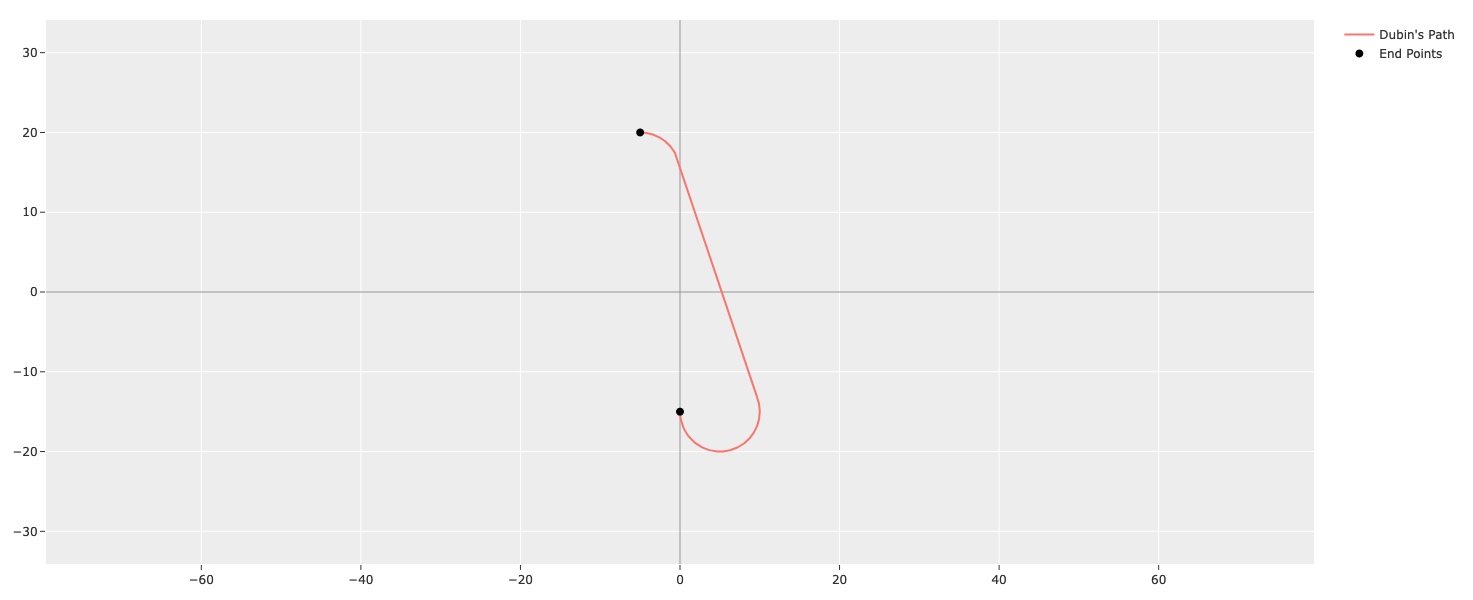

In [8]:
plot_dubin(["Dubin's Path", "lines", optimal_path]).show()

## Creating the Car Model

In [9]:
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix

In [10]:
d_t, s = symbols('dt, s')
a = Matrix([
    [x + d_t * s * sympy.cos(theta)],
    [y + d_t * s * sympy.sin(theta)],
    [theta]
])

A = a.jacobian(Matrix([x, y, theta]))

In [11]:
y_1, x_1, y_2, x_2 = symbols('y_1, x_1, y_2, x_2')
b = Matrix([
    [sympy.atan2((y - y_1), (x - x_1))],
    [sympy.atan2((y - y_2), (x - x_2))],
    [theta]
])
B = b.jacobian(Matrix([x, y, theta]))
B

⎡       -y + y₁                 x - x₁          ⎤
⎢─────────────────────  ─────────────────────  0⎥
⎢        2           2          2           2   ⎥
⎢(x - x₁)  + (y - y₁)   (x - x₁)  + (y - y₁)    ⎥
⎢                                               ⎥
⎢       -y + y₂                 x - x₂          ⎥
⎢─────────────────────  ─────────────────────  0⎥
⎢        2           2          2           2   ⎥
⎢(x - x₂)  + (y - y₂)   (x - x₂)  + (y - y₂)    ⎥
⎢                                               ⎥
⎣          0                      0            1⎦

### Calculating the True Vehicle Path

In [12]:
lti = LTI(s=1, s_var=0.05, dt=0.5, x0=optimal_path[0], dubins_path=optimal_path, q1=q1)
lti.x_t_noise(x=[np.array([optimal_path[0]])], )

#### Plotting the Path

In [13]:
simple_trajectory = [list(a[0]) for a in lti.trajectory]
# simple_trajectory

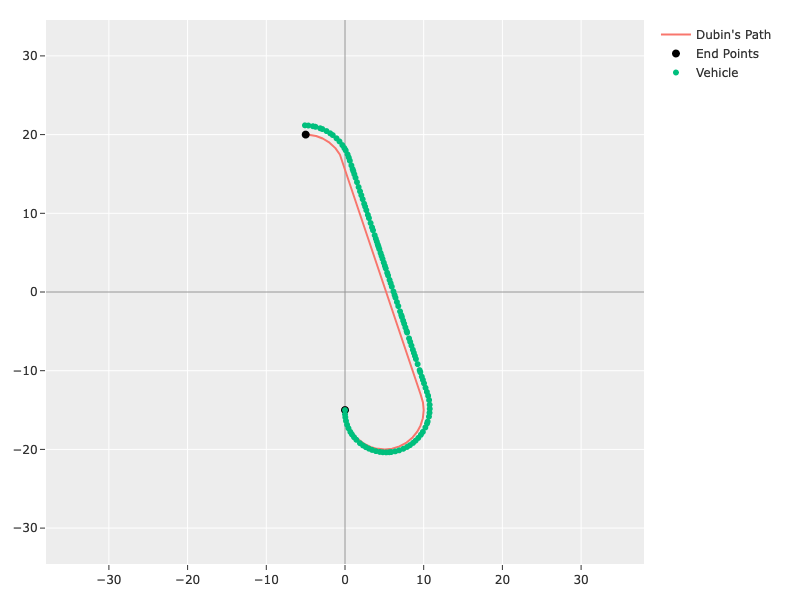

In [14]:
plot_dubin(["Dubin's Path", "lines", optimal_path], ["Vehicle", "markers", simple_trajectory]).show()

## Implementing a Simple, Noisy Bearing Calc

In [15]:
# I added in the distance from the radar to make plotting easier
def two_radar_est(lti: LTI, radar_1: Radar, radar_2: Radar) -> list:
    y = []
    f_var = multivariate_normal(mean=np.zeros(3), cov=np.diag([radar_1.v / (rad_to_deg) ** 2, radar_2.v / (rad_to_deg) ** 2, 5 / rad_to_deg]))
    for x in lti.trajectory:
        var = f_var.rvs()
        
        state = dict(x=x[0][0], 
                     y=x[0][1],
                     x1=radar_1.x, 
                     x2=radar_2.x,
                     y1=radar_1.y, 
                     y2=radar_2.y, 
                     theta=x[0][2])

        y_k = lti.measure(**state, noise_matrix=var)

        y_k = np.r_[
            y_k[0] * rad_to_deg, 
            np.linalg.norm(np.array(x[0][:-1]) - np.array((radar_1.x, radar_1.y))), 
            np.linalg.norm(np.array(x[0][:-1]) - np.array((radar_2.x, radar_2.y)))
           ]
        y.append(
            y_k
        )
    return y

### Radars at (−15, −10) and (−15, 5)

In [16]:
radar_1 = Radar(x=-15, y=-10, v=9)
radar_2 = Radar(x=-15, y=5, v=9)
bearing = two_radar_est(lti, Radar(x=-15, y=-10, v=9), Radar(x=-15, y=5, v=9))

#### Plotting the Bearing

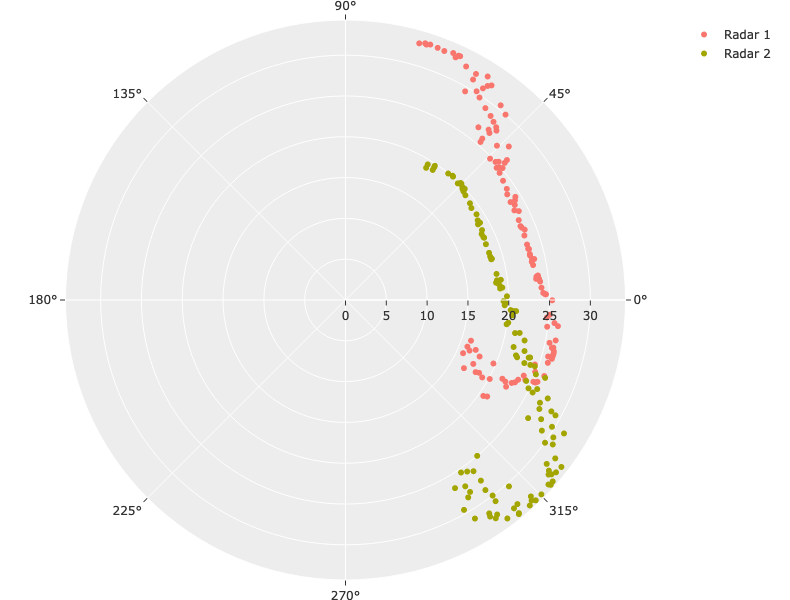

In [17]:
fig = go.Figure()

fig.add_trace(
    go.Scatterpolar(
        r = [b[3] for b in bearing],
        theta = [b[0] for b in bearing],
        mode = 'markers',
        name="Radar 1"
    )
)

fig.add_trace(
    go.Scatterpolar(
        r = [b[4] for b in bearing],
        theta = [b[1] for b in bearing],
        mode = 'markers',
        name="Radar 2"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    height=600, width=600,
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    xaxis_range=[-25, 25],
    yaxis_range=[-25, 25],
)

fig.show()

#### using the bearing and the distance to plot in XY

In [18]:
x_y_1_close = [(radar_1.x + np.cos(b[0] / rad_to_deg) * b[3], radar_1.y + np.sin(b[0] / rad_to_deg) * b[3], b[2]) for b in bearing]
x_y_2_close = [(radar_2.x + np.cos(b[1] / rad_to_deg) * b[4], radar_2.y + np.sin(b[1] / rad_to_deg) * b[4], b[2]) for b in bearing]

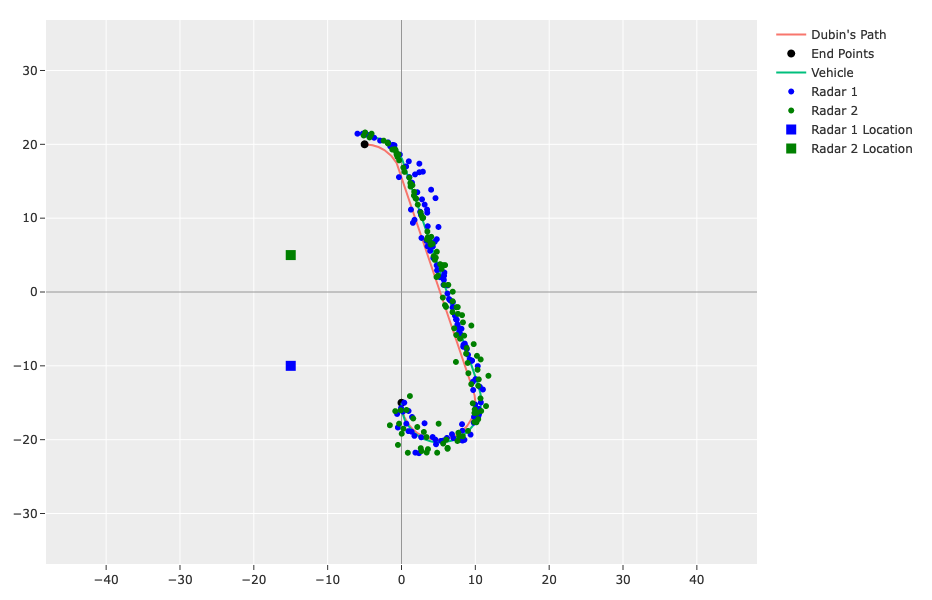

In [19]:
fig = plot_dubin(["Dubin's Path", "lines", optimal_path], 
           ["Vehicle", "lines", simple_trajectory], 
           ["Radar 1", "markers", x_y_1_close],
           ["Radar 2", "markers", x_y_2_close])

fig.data[3].line.color = "blue"
fig.data[4].line.color = "green"

fig.add_trace(
    go.Scatter(
        x=[radar_1.x],
        y=[radar_1.y],
        name='Radar 1 Location',
        mode="markers",
        marker_size=10,
        marker_color="blue",
        marker_symbol="square"
    )
)

fig.add_trace(
    go.Scatter(
        x=[radar_2.x],
        y=[radar_2.y],
        name='Radar 2 Location',
        mode="markers",
        marker_size=10,
        marker_color="green",
        marker_symbol="square"
    )
)


fig.show()

## Estimate the Postition of the Ground Vehicle Using EKFs

### Radar at (−15, −10) and (−15, 5)

In [24]:
# Givens
dt = 0.5
R = 5
radar_1_close = Radar(x=-15, y=-10, v=9)
radar_2_close = Radar(x=-15, y=5, v=9)

lti = LTI(s=1, s_var=0.05, dt=dt,
          x0=optimal_path[0], dubins_path=optimal_path, q1=q1)

lti.x_t_noise(x=[np.array([optimal_path[0]])], )

e = EKF(lti, 
        R=np.diag([radar_1_close.v / (rad_to_deg ** 2), radar_2_close.v / (rad_to_deg ** 2), 5 / (rad_to_deg ** 2)]),
        Q=np.diag([0.05, 0.05, (1 / R) ** 2 * dt ** 2]), radars=(radar_1_close, radar_2_close))

res_close = e.run("silent")

### Plotting Computed Path vs. "Actual" Trajectory, Close Radar

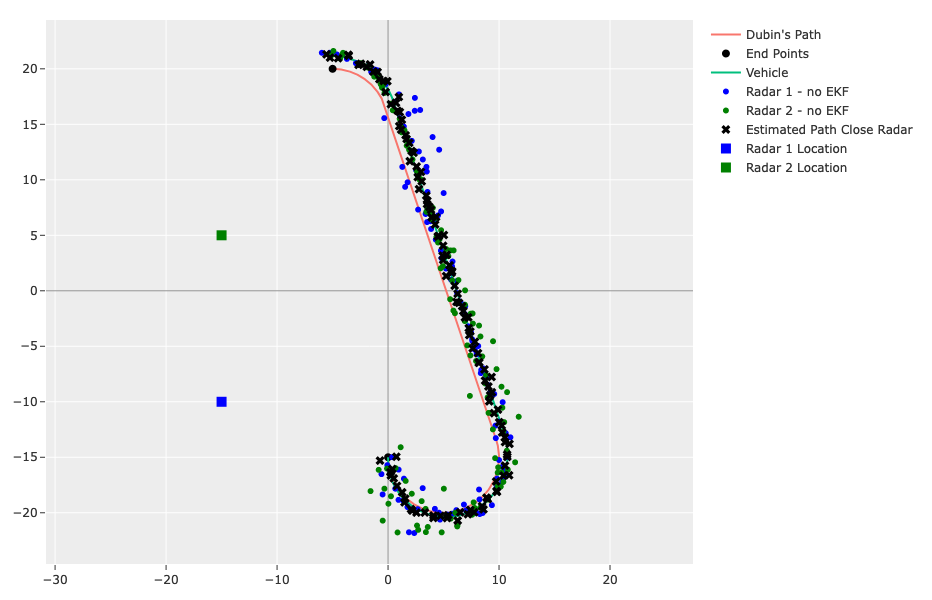

In [26]:
fig = plot_dubin(
                 ["Dubin's Path", "lines", optimal_path],
                 ["Vehicle", "lines", simple_trajectory],
                 ["Radar 1 - no EKF", "markers", x_y_1_close],
                 ["Radar 2 - no EKF", "markers", x_y_2_close],
                 ["Estimated Path Close Radar", "markers", [r.x_k_k.T[0] for r in res_close]],
                 # ["Estimated Path Far Radar", "markers", [r.x_k_k.T[0] for r in res_far]],
    

)

fig.data[3].line.color = "blue"
fig.data[4].line.color = "green"

fig.add_trace(
    go.Scatter(
        x=[radar_1_close.x],
        y=[radar_1_close.y],
        name='Radar 1 Location',
        mode="markers",
        marker_size=10,
        marker_color="blue",
        marker_symbol="square"
    )
)

fig.add_trace(
    go.Scatter(
        x=[radar_2_close.x],
        y=[radar_2_close.y],
        name='Radar 2 Location',
        mode="markers",
        marker_size=10,
        marker_color="green",
        marker_symbol="square"
    )
)

fig.data[-3].marker.symbol = 'x'
fig.data[-3].marker.size = 8
fig.data[-3].marker.color = "black"

fig.update_layout(xaxis_range=None, yaxis_range=None)

fig.show()

#### Plotting with select covariance ellipse (every 3)

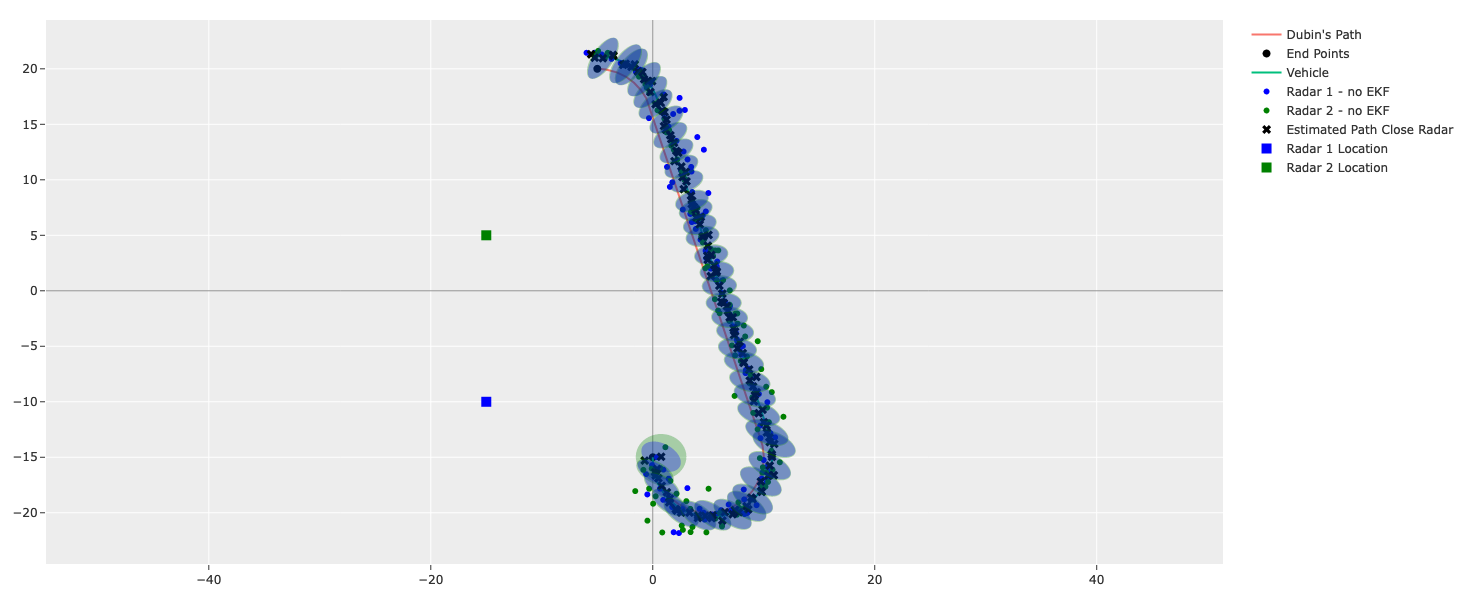

In [27]:
for res in res_close[::3]:
    path = confidence_ellipse(x=res.x_k_k[0, 0], y=res.x_k_k[1, 0], cov=res.P_k_k[:2, :2], n_std=2, size=50)
    priori_path = confidence_ellipse(x=res.x_k_k[0, 0], y=res.x_k_k[1, 0], cov=res.P_k_k_1[:2, :2], n_std=2, size=50)
    
    fig.add_shape(
        type='path',
        path=priori_path,
        line={'dash': 'dot'},
        line_color="green",
        fillcolor="green",
    )
    
    fig.add_shape(
        type='path',
        path=path,
        line={'dash': 'dot'},
        fillcolor="blue"
    )
    

fig.show()

### Plotting _a posteriori_ states

#### $\hat{x}_{k|k}$

In [30]:
t = [i * dt for i in range(len(res_close))]
x_k_k_close = [r.x_k_k.T[0][0] for r in res_close]
x_k_k_far = [r.x_k_k.T[0][0] for r in res_far]
x_act = [x[0] for x in simple_trajectory]
x_std_close = [r.P_k_k[0][0] ** (1 / 2) * 2 for r in res_close]
x_std_far = [r.P_k_k[0][0] ** (1 / 2) * 2 for r in res_far]

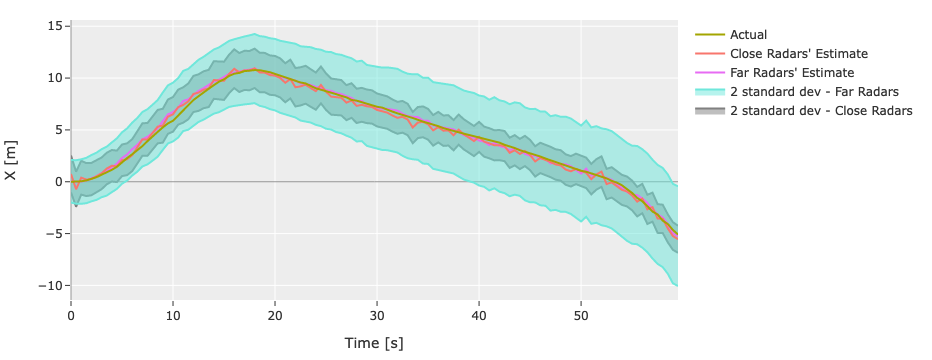

In [31]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_far, x_std_far)],
        # fill='tonexty',
        line_color='rgb(111, 231, 219)',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_far, x_std_far)],
        # fill='',
        fill='tonexty',
        line_color='rgb(111, 231, 219)',
        name="2 standard dev - Far Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_far,
        name="Far Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_act,
        name="Actual"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="X [m]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

#### $\hat{y}_{k|k}$

In [32]:
t = [i * dt for i in range(len(res_close))]
x_k_k_close = [r.x_k_k.T[0][1] for r in res_close]
x_k_k_far = [r.x_k_k.T[0][1] for r in res_far]
x_act = [x[1] for x in simple_trajectory]
x_std_close = [r.P_k_k[1][1] ** (1 / 2) * 2 for r in res_close]
x_std_far = [r.P_k_k[1][1] ** (1 / 2) * 2 for r in res_far]

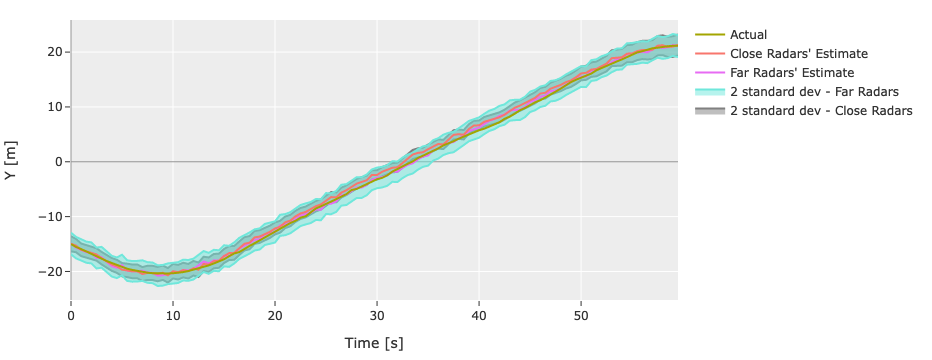

In [33]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_far, x_std_far)],
        # fill='tonexty',
        line_color='rgb(111, 231, 219)',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_far, x_std_far)],
        # fill='',
        fill='tonexty',
        line_color='rgb(111, 231, 219)',
        name="2 standard dev - Far Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_far,
        name="Far Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_act,
        name="Actual"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Y [m]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

#### $\hat{\theta}_{k|k}$

In [34]:
t = [i * dt for i in range(len(res_close))]
x_k_k_close = [r.x_k_k.T[0][2] * rad_to_deg for r in res_close]
x_k_k_far = [r.x_k_k.T[0][2] * rad_to_deg for r in res_far]
x_act = [x[2] * rad_to_deg for x in simple_trajectory]
x_std_close = [r.P_k_k[2][2] ** (1 / 2) * 2 * rad_to_deg for r in res_close]
x_std_far = [r.P_k_k[2][2] ** (1 / 2) * 2 * rad_to_deg for r in res_far]

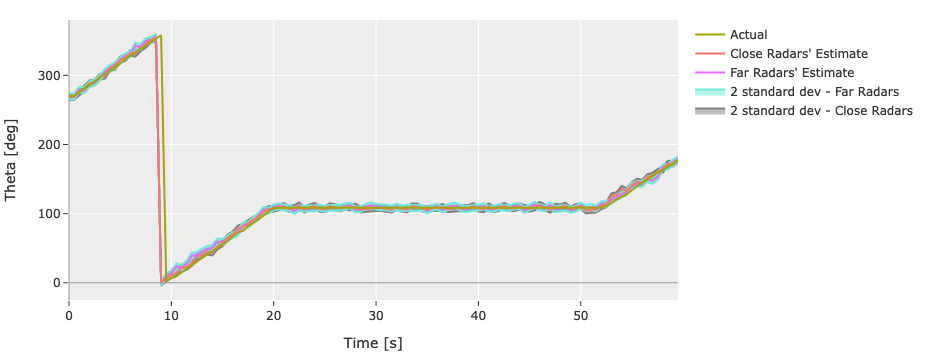

In [35]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_far, x_std_far)],
        # fill='tonexty',
        line_color='rgb(111, 231, 219)',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_far, x_std_far)],
        # fill='',
        fill='tonexty',
        line_color='rgb(111, 231, 219)',
        name="2 standard dev - Far Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_far,
        name="Far Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_act,
        name="Actual"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Theta [deg]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

### Plotting the Innovation

#### $\beta_{1, k}$

In [36]:
t = [i * dt for i in range(len(res_close))]
x_k_k_close = [r.y_k[0][0] * rad_to_deg for r in res_close]
x_std_close = [r.S_k[0][0] ** (1 / 2) * 2 *rad_to_deg for r in res_close]
x_k_k_far = [r.y_k[0][0] * rad_to_deg for r in res_far]
x_std_far = [r.S_k[0][0] ** (1 / 2) * 2 *rad_to_deg for r in res_far]

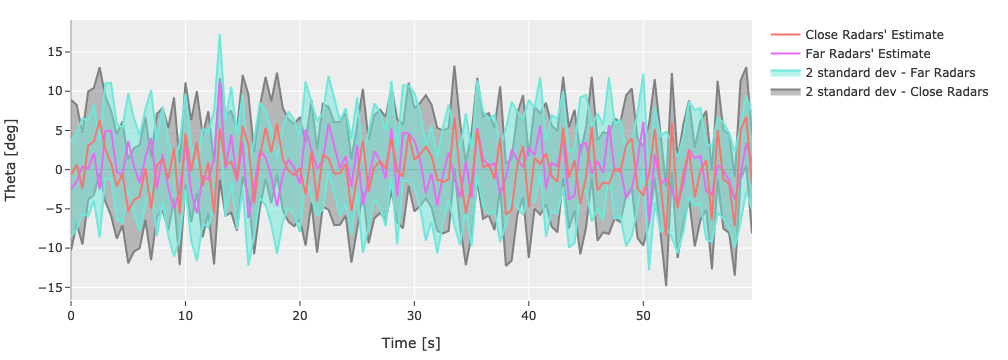

In [37]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_far, x_std_far)],
        # fill='tonexty',
        line_color='rgb(111, 231, 219)',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_far, x_std_far)],
        # fill='',
        fill='tonexty',
        line_color='rgb(111, 231, 219)',
        name="2 standard dev - Far Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_far,
        name="Far Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Theta [deg]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

#### $\beta_{2,k}$

In [38]:
t = [i * dt for i in range(len(res_close))]
x_k_k_close = [r.y_k[0][1] * rad_to_deg for r in res_close]
x_std_close = [r.S_k[0][1] ** (1 / 2) * 2 *rad_to_deg for r in res_close]
x_k_k_far = [r.y_k[0][1] * rad_to_deg for r in res_far]
x_std_far = [r.S_k[0][1] ** (1 / 2) * 2 *rad_to_deg for r in res_far]

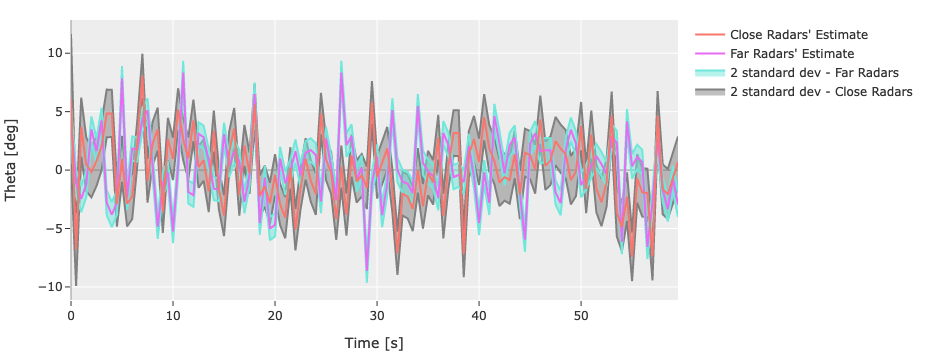

In [39]:
fig = go.Figure()


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='tonexty',
        line_color='grey',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_close, x_std_close)],
        # fill='',
        fill='tonexty',
        line_color='grey',
        name="2 standard dev - Close Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=[x + std for x, std in zip(x_k_k_far, x_std_far)],
        # fill='tonexty',
        line_color='rgb(111, 231, 219)',
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=[x - std for x, std in zip(x_k_k_far, x_std_far)],
        # fill='',
        fill='tonexty',
        line_color='rgb(111, 231, 219)',
        name="2 standard dev - Far Radars"
    )
)


fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_far,
        name="Far Radars' Estimate"
    )
)

fig.add_trace(
    go.Scatter(
        x=t,
        y=x_k_k_close,
        name="Close Radars' Estimate"
    )
)

fig.update_layout(
    margin=dict(l=20, r=20, b=20, t=20),
    # height=600, width=600,
    # yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis_zeroline=True,
    yaxis_zeroline=True,
    xaxis_zerolinecolor='#969696',
    yaxis_zerolinecolor='#969696',
    yaxis_title="Theta [deg]",
    xaxis_title="Time [s]"
    # xaxis_range=[-25, 25],
    # yaxis_range=[-25, 25],
)

## Comment on the plots and the differences between the sets of radars

When not using an EKF, the close radar performs better than the further radar by a wide margin. The error is most pronounced near the "hook" of the path. When using EKF, the two sets of radar (close and far) perform nearly identicaly. The covariance of the estimate is greatest in the begging, with the covariance of the _a priori_ and _a posteriori_ eventually converging